In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('train.csv')

In [3]:
kaggle_images = df.iloc[:,1:].as_matrix()
kaggle_labels = df.iloc[:,:1].as_matrix()

In [17]:
(keras_train_images, keras_train_labels), (keras_eval_images, keras_eval_labels) = tf.keras.datasets.mnist.load_data('data')
keras_train_images = keras_train_images.reshape(-1, 784)
keras_eval_images = keras_eval_images.reshape(-1, 784)
keras_train_labels = keras_train_labels.astype(np.int32)
keras_eval_labels = keras_eval_labels.astype(np.int32)

In [5]:
predict_images = pd.read_csv('test.csv').as_matrix()

In [6]:
def train_input_fn(features, labels, batch_size=10):
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.apply(tf.contrib.data.shuffle_and_repeat(1000))
    return dataset.batch(batch_size)

In [7]:
def eval_input_fn(features, labels, batch_size=10):
    return tf.data.Dataset.from_tensor_slices((features, labels)).batch(batch_size)

In [8]:
def predict_input_fn(features, batch_size=10):
    return tf.data.Dataset.from_tensor_slices(features).batch(batch_size)

In [9]:
def train_fn(logits, loss, labels, predicted_classes):
    accuracy = tf.metrics.accuracy(labels, predicted_classes, name='acc_op')
    tf.summary.scalar('accuracy', accuracy[1])
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(loss, tf.train.get_or_create_global_step())
    return tf.estimator.EstimatorSpec(
        tf.estimator.ModeKeys.TRAIN, loss=loss, train_op=train_op)

In [10]:
def eval_fn(logits, loss, labels, predicted_classes):
    accuracy = tf.metrics.accuracy(labels, predicted_classes, name='acc_op')
    metrics = {'accuracy': accuracy}
    tf.summary.scalar('accuracy', accuracy[1])
    return tf.estimator.EstimatorSpec(
        tf.estimator.ModeKeys.EVAL, loss=loss, eval_metric_ops=metrics)

In [11]:
def predict_fn(logits, predicted_classes):
    return tf.estimator.EstimatorSpec(
        tf.estimator.ModeKeys.PREDICT, predictions=predicted_classes)

In [12]:
def model_fn(features, labels, mode, params):
    X = tf.feature_column.input_layer(features, params['feature_columns'])
    X = tf.reshape(X, shape=[-1, 28, 28, 1])
    X = tf.keras.layers.Conv2D(filters=30, kernel_size=5, activation=tf.nn.relu)(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Conv2D(filters=30, kernel_size=5, activation=tf.nn.relu)(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Conv2D(filters=30, kernel_size=5, activation=tf.nn.relu)(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dense(units=100, activation=tf.nn.relu)(X)
    X = tf.keras.layers.Dense(units=50, activation=tf.nn.relu)(X)
    logits = tf.keras.layers.Dense(params['n_classes'], activation=tf.nn.relu)(X)
    predicted_classes = tf.argmax(logits, 1)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return predict_fn(logits, predicted_classes)
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels, logits)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        return train_fn(logits, loss, labels, predicted_classes)
    
    if mode == tf.estimator.ModeKeys.EVAL:
        return eval_fn(logits, loss, labels, predicted_classes)

In [13]:
feature_columns = [tf.feature_column.numeric_column('images', shape=[784])]

In [14]:
classifier = tf.estimator.Estimator(
    model_fn, 
    model_dir='model',
    params={
        'feature_columns': feature_columns, 
        'n_classes': 10
    })

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8b5225e940>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [28]:
classifier.train(lambda: train_input_fn({'images': kaggle_images}, kaggle_labels), steps=50000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 20001 into model/model.ckpt.
INFO:tensorflow:loss = 0.0002981133, step = 20000
INFO:tensorflow:global_step/sec: 151.054
INFO:tensorflow:loss = 0.00044321478, step = 20100 (0.663 sec)
INFO:tensorflow:global_step/sec: 213.38
INFO:tensorflow:loss = 1.8834082e-05, step = 20200 (0.469 sec)
INFO:tensorflow:global_step/sec: 209.841
INFO:tensorflow:loss = 0.0048058312, step = 20300 (0.476 sec)
INFO:tensorflow:global_step/sec: 214.134
INFO:tensorflow:loss = 3.866909e-05, step = 20400 (0.470 sec)
INFO:tensorflow:global_step/sec: 209.744
INFO:tensorflow:loss = 0.00031700052, step = 20500 (0.475 sec)
INFO:tensorflow:global_step/sec: 203.291
INFO:tensorflow:loss =

In [29]:
classifier.train(lambda: train_input_fn({'images': keras_train_images}, keras_train_labels), steps=50000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model/model.ckpt-70000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 70001 into model/model.ckpt.
INFO:tensorflow:loss = 8.583039e-07, step = 70000
INFO:tensorflow:global_step/sec: 150.687
INFO:tensorflow:loss = 8.990915e-05, step = 70100 (0.665 sec)
INFO:tensorflow:global_step/sec: 205.558
INFO:tensorflow:loss = 0.0027153061, step = 70200 (0.486 sec)
INFO:tensorflow:global_step/sec: 213.996
INFO:tensorflow:loss = 0.18385433, step = 70300 (0.467 sec)
INFO:tensorflow:global_step/sec: 210.755
INFO:tensorflow:loss = 0.008299479, step = 70400 (0.474 sec)
INFO:tensorflow:global_step/sec: 216.541
INFO:tensorflow:loss = 5.8291816e-06, step = 70500 (0.462 sec)
INFO:tensorflow:global_step/sec: 210.929
INFO:tensorflow:loss = 4.5

In [30]:
classifier.evaluate(lambda: eval_input_fn({'images': keras_eval_images}, keras_eval_labels))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-10-14:59:04
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model/model.ckpt-120000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-10-14:59:06
INFO:tensorflow:Saving dict for global step 120000: accuracy = 0.9957, global_step = 120000, loss = 0.018113049


{'accuracy': 0.9957, 'global_step': 120000, 'loss': 0.018113049}

In [31]:
predictions = list(classifier.predict(lambda: predict_input_fn({'images': predict_images})))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model/model.ckpt-120000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [32]:
def show_prediction(index):
    plt.imshow(predict_images[index].reshape(28, 28))
    print(f'prediction: {predictions[index]}')

prediction: 2


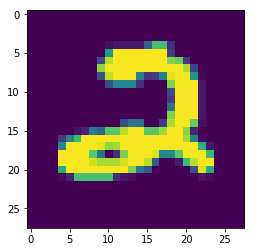

In [33]:
show_prediction(0)

prediction: 0


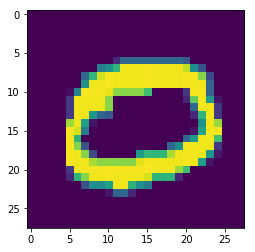

In [34]:
show_prediction(1)

prediction: 9


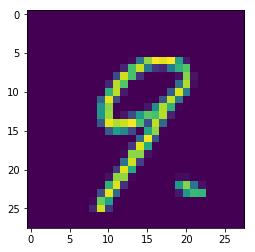

In [35]:
show_prediction(2)

prediction: 0


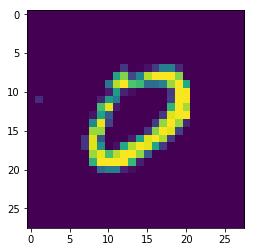

In [36]:
show_prediction(3)

prediction: 3


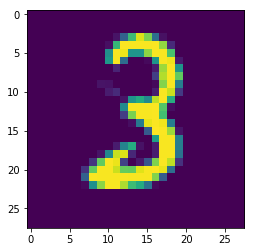

In [37]:
show_prediction(4)

In [38]:
submissions = pd.DataFrame({'ImageId': range(1, len(predictions) + 1), 'Label': predictions})

In [39]:
submissions.to_csv('submissions.csv', index=False)